In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

In [18]:
DATA_FOLDER = Path("../input/fruits/fruits-360_dataset/fruits-360")
TRAIN = DATA_FOLDER / 'Training'

In [19]:
for i,fruit_class in enumerate(TRAIN.iterdir()):
    print(fruit_class.stem)
    if i > 5: break

Quince
Grapefruit White
Granadilla
Orange
Apple Red 3
Grape White 2
Corn Husk


In [20]:
from tqdm import tqdm
from PIL import Image
import random

def load_data(path, sample=30, shuffle=True):
    res = []
    for fruit_class in tqdm(path.iterdir()):
        for i,image in enumerate(fruit_class.iterdir()):
            res.append((np.array(Image.open(image)),
                        fruit_class.stem,
                        image.stem))
            if i > sample:
                break
    if shuffle:
        random.shuffle(res)
            
    return res

train = load_data(TRAIN)

131it [00:04, 32.02it/s]


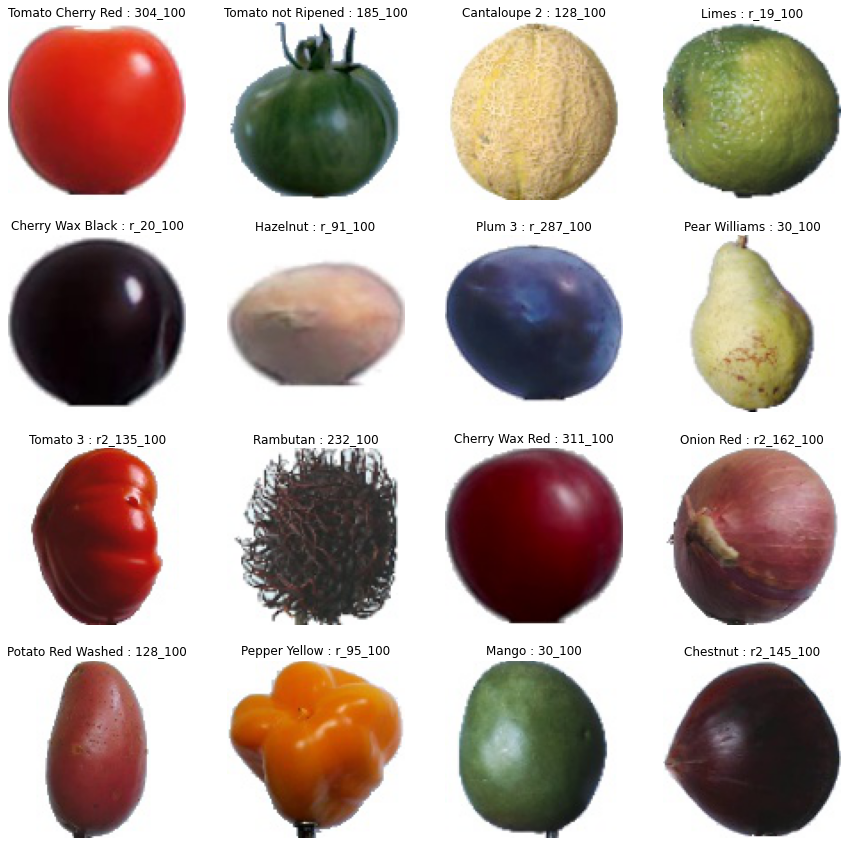

In [21]:
fig,axes = plt.subplots(4,4,figsize=(15,15))
imgs,labels,fnames = zip(*train)

for img,label,fname,ax in zip(imgs,labels,fnames,axes.ravel()):
    plt.sca(ax)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label + " : " + fname )
plt.show()

In [22]:
import copy
labels_copy = list(set(copy.copy(labels)))
random.shuffle(labels_copy)
selected_labels = labels_copy[:20]

In [23]:
selected_labels

['Peach 2',
 'Orange',
 'Mulberry',
 'Grapefruit White',
 'Raspberry',
 'Pomelo Sweetie',
 'Hazelnut',
 'Plum 3',
 'Eggplant',
 'Corn',
 'Apple Crimson Snow',
 'Mango',
 'Apple Granny Smith',
 'Guava',
 'Apple Red Delicious',
 'Carambula',
 'Banana',
 'Onion White',
 'Dates',
 'Chestnut']

In [24]:
from collections import defaultdict
acc = defaultdict(list)
for image, label in zip(imgs,labels):
    if label in selected_labels:
        acc[label].append(image.mean((0,1),where=image!=255))

acc = {k:np.array(v) for k,v in acc.items()}

In [25]:
acc.keys()

dict_keys(['Hazelnut', 'Plum 3', 'Mango', 'Chestnut', 'Raspberry', 'Apple Crimson Snow', 'Grapefruit White', 'Apple Red Delicious', 'Mulberry', 'Guava', 'Corn', 'Peach 2', 'Banana', 'Eggplant', 'Orange', 'Carambula', 'Pomelo Sweetie', 'Apple Granny Smith', 'Dates', 'Onion White'])

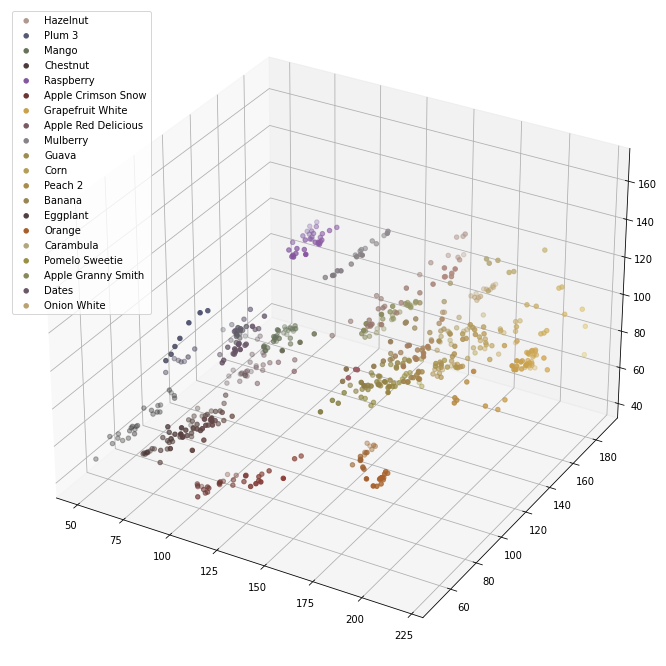

In [26]:
import matplotlib.pyplot as plt
import random

def unstack(a, axis = 0):
    return [np.squeeze(e, axis) for e in np.split(a, a.shape[axis], axis = axis)]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for name, rgb_vals in acc.items():
    r,g,b = unstack(rgb_vals,1)
    c = np.array([r,g,b]).T / 255.
    ax.scatter(
        r,g,b,
        c = c,
        label=name
    )
plt.legend()
plt.show()

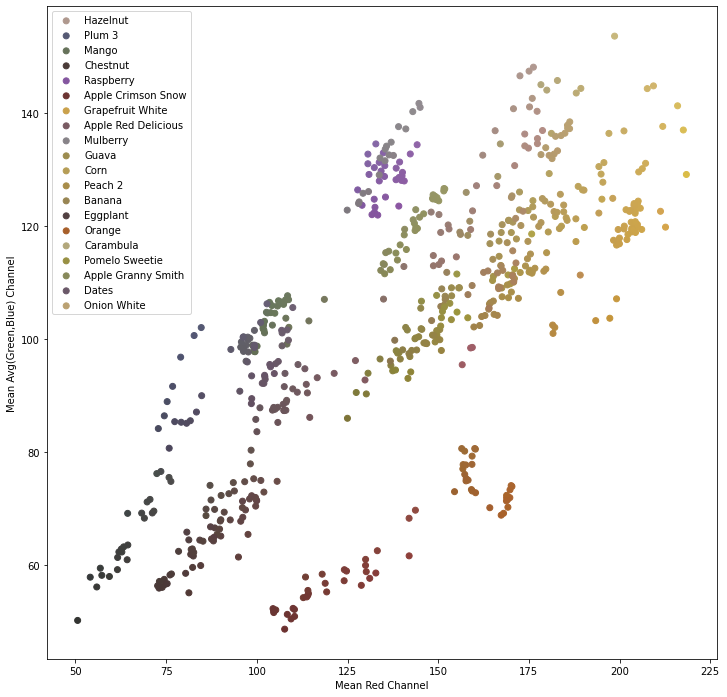

In [30]:
import matplotlib.pyplot as plt
import random

def unstack(a, axis = 0):
    return [np.squeeze(e, axis) for e in np.split(a, a.shape[axis], axis = axis)]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

for name, rgb_vals in acc.items():
    r,g,b = unstack(rgb_vals,1)
    c = np.array([r,g,b]).T / 255.
    
    ax.scatter(
        r,(g+b)/2,
        c = c,
        label=name
    )
    plt.xlabel('Mean Red Channel')
    plt.ylabel('Mean Avg(Green,Blue) Channel')
plt.legend()
plt.show()

In [ ]:
sns.displot(data=penguins, x="flipper_length_mm", hue="species", kind="kde")